In [197]:
import numpy as np
from bregman.suite import * 
import tensorflow as tf
import matplotlib.pyplot as plt
from basic_units import cm, inch

In [198]:
filenames = tf.train.match_filenames_once('./audio_dataset/*.wav')
count_num_files = tf.size(filenames)
filename_queue = tf.train.string_input_producer(filenames)
reader = tf.WholeFileReader()
filename, file_contents = reader.read(filename_queue)

In [199]:
chroma = tf.placeholder(tf.float32)
max_freqs = tf.argmax(chroma, 0)

In [200]:
def get_next_chromagram(sess):
    audio_file = sess.run(filename)
    F = Chromagram(audio_file, nfft=16384, wfft=8192, nhop=2205)
    return F.X

In [201]:
def extract_feature_vector(sess, chroma_data):
    num_features, num_samples = np.shape(chroma_data)
    freq_vals = sess.run(max_freqs, feed_dict = {chroma: chroma_data})
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    return hist.astype(float) / num_samples

In [202]:
def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    xs = []
    for _ in range(num_files):
        chroma_data = get_next_chromagram(sess)
        x = [extract_feature_vector(sess, chroma_data)]
        x = np.matrix(x)
        if len(xs) == 0:
            xs = x
        else:
            xs = np.vstack((xs, x))
    
    return xs

In [203]:
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    X = get_dataset(sess)
    
print(X)
print(X.shape)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, assertion failed: [string_input_producer requires a non-null input tensor]
	 [[{{node input_producer_1/Assert/Assert}}]]
[[0.09090909 0.22727273 0.09090909 0.04545455 0.09090909 0.04545455
  0.04545455 0.         0.         0.18181818 0.09090909 0.09090909]
 [0.08       0.         0.         0.         0.04       0.16
  0.32       0.28       0.12       0.         0.         0.        ]
 [0.4516129  0.         0.16129032 0.03225806 0.         0.
  0.12903226 0.03225806 0.03225806 0.         0.16129032 0.        ]
 [0.02985075 0.         0.         0.         0.7761194  0.02985075
  0.         0.1641791  0.         0.         0.         0.        ]
 [0.04081633 0.         0.         0.04081633 0.42857143 0.48979592
  0.         0.         0.         0.         0.         0.        ]]
(5, 12)


[ 0.03  1.03  2.03  3.03  4.03  5.03  6.03  7.03  8.03  9.03 10.03 11.03]


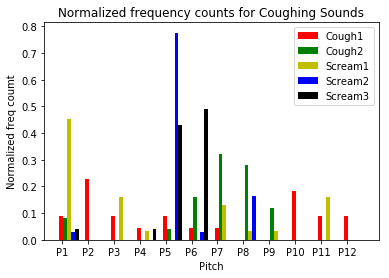

In [223]:
labels=[]
for i in np.arange(12):
    labels.append("P"+str(i+1))
    
fig, ax = plt.subplots()
ind = np.arange(len(labels))
width = 0.15 
colors = ['r', 'g', 'y', 'b', 'black']
plots = []

for i in range(X.shape[0]):
    Xs = np.asarray(X[i]).reshape(-1)
    p = ax.bar(ind + i*width, Xs, width, color=colors[i])
    plots.append(p[0])

xticks = ind + width / (X.shape[0])
print(xticks)
ax.legend(tuple(plots), ('Cough1', 'Cough2', 'Scream1', 'Scream2', 'Scream3'))
ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.set_ylabel('Normalized freq coumt')
ax.set_xlabel('Pitch')
ax.set_title('Normalized frequency counts for Coughing Sounds')
plt.show()